In [ ]:
#default_exp augmentations

## augmentations
Implmentation heavily inspired by Ignacio Oguiza - oguiza@gmail.com

In [ ]:
#export
import numpy as np
import random
from functools import partial
from scipy.interpolate import CubicSpline
import torch

In [ ]:
from fastai2.torch_basics import *
from fastai2.data.all import *

### TS foundations

In [ ]:
def show_ts(ts):
    '''
    plot a timeseries item
    '''
    print('show_ts')
    if ts.ndim==3: ts=ts[0]
    nrows = math.ceil(ts.shape[0]/2)
    ncols = 1 if ts.shape[0]<=1 else 2
    fg, axs = plt.subplots(nrows,ncols, figsize=(5,5))
    for i, ax in enumerate(fg.axes):
    #     print(ax)
    #     ax.set_title(str(i))
        ax.plot(ts[i])
    return fg

class TSItem:
    def __init__(self, data):
        self.data = data
        self.channels, self.seq_len = data.shape
        
    def show(self, ctx=None):
        return show_ts(self.data)

def show_batch(x: TSItem, y):
    print('show_batch')
    show_ts(x)

class TSTensor(TensorBase): 
    def show(self, ctx=None):
        print('TSTensor show')
        return show_ts(self)

class TensorFloat(TensorBase):
    '''
    float target value of a timeseries
    ctx expected to be a `Figure` object
    '''
    _show_args={}
    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        ctx.suptitle(f'Label: {self.numpy()}', fontsize=16)
        return ctx

### Augs

In [ ]:
#exports
def random_curve_generator(ts, magnitude=.1, order=4, noise=None):
    seq_len = ts.shape[-1]
    x = np.linspace(-seq_len, 2 * seq_len - 1, 3 * (order - 1) + 1, dtype=int)
    x2 = np.random.normal(loc=1.0, scale=magnitude, size=len(x))
    f = CubicSpline(x, x2, axis=-1)
    return f(np.arange(seq_len))


def random_cum_curve_generator(ts, magnitude=.1, order=4, noise=None):
    x = random_curve_generator(ts, magnitude=magnitude, order=order, noise=noise).cumsum()
    x -= x[0]
    x /= x[-1]
    x = np.clip(x, 0, 1)
    return x * (ts.shape[-1] - 1)


def random_cum_noise_generator(ts, magnitude=.1, noise=None):
    seq_len = ts.shape[-1]
    x = (np.ones(seq_len) + np.random.normal(loc=0, scale=magnitude, size=seq_len)).cumsum()
    x -= x[0]
    x /= x[-1]
    x = np.clip(x, 0, 1)
    return x * (ts.shape[-1] - 1)

In [ ]:
#export
def magnoise(x, magnitude=.1, add=True):
    if magnitude <= 0: return x
    y = None
    if isinstance(x, list):
        y = x[1]
        x = x[0]
    seq_len = x.shape[-1]
    noise = torch.normal(0, magnitude, (1, seq_len), dtype=x.dtype, device=x.device)
    if add:
        output = x + noise
        return output if y is None else [output, y]
    else:
        output = x * (1 + noise)
        return output if y is None else [output, y]

In [ ]:
magnoise(torch.tensor([2.1]))

tensor([[2.3728]])

In [ ]:
#export
def timewarp(x, magnitude=.1, order=4):
    '''This is a slow batch tfm on cpu'''
    if magnitude <= 0: return x
    y = None
    if isinstance(x, list):
        y = x[1]
        x = x[0]
    seq_len = x.shape[-1]
    x_device = x.device ## make sure to put outpout on right device
    x=x.cpu()

    f = CubicSpline(np.arange(seq_len), x, axis=-1)
    new_x = random_cum_curve_generator(x, magnitude=magnitude, order=order)
    output = x.new(f(new_x))
    return output.to(x_device) if y is None else [output.to(x_device), y]


In [ ]:
#export
def magwarp(x, magnitude=.1, order=4):
    if magnitude <= 0: return x
    y = None
    if isinstance(x, list):
        y = x[1]
        x = x[0]
    y_mult = random_curve_generator(x, magnitude=magnitude, order=order)
    output = x * x.new(y_mult)
    return output if y is None else [output, y]


In [ ]:
def _timenoise(x, magnitude=.1):
    '''This is a slow batch tfm, requires cpu'''
    if magnitude <= 0: return x
    f = CubicSpline(np.arange(x.shape[-1]), x, axis=-1)
    new_x = random_cum_noise_generator(x, magnitude=magnitude)
    output = x.new(f(new_x))
    return output

In [ ]:
class TimeNoise(Transform):
    order=200
    def encodes(self, x:TSTensor):
        print('magwarp')
        return _timenoise(x.to('cpu')).to(default_device())

In [ ]:
t = torch.randn((4,20))

In [ ]:
ts_tensor = TSTensor(t)

show_ts


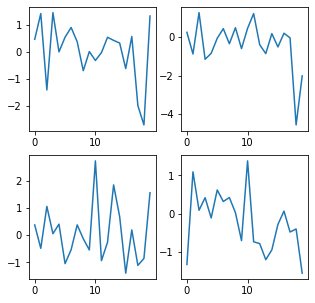

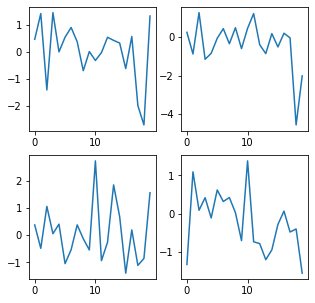

In [ ]:
TSItem(ts_tensor).show()

In [ ]:
TSItem(TimeNoise()(ts_tensor)).show()

magwarp


RuntimeError: CUDA error: out of memory

In [ ]:
# res = timewarp([t.to('cuda'), torch.tensor([0., 0.])])